# Car Purchase Prediction Model 
## Workflow
    1. data loading & imports
    2. EDA/understanding data ( finding about missing values,outliers,skewedness in data)
    3. feature engineering & scaling ( in outliers/skewed data is found)
    4. model development ( model selection, training & optimization, evalution)
    5. saving model and weights to use it in flask app 

# 1.Data Loading & Imports

In [1]:
import pandas as pd # basic imports

import matplotlib.pyplot as plt # visualization of dataset
plt.style.use('ggplot')
import seaborn as sns # visualization of dataset

import plotly.express as px # for interactive visualisation

import lightgbm as lgb # I will use lightgbm algorithm as it is good model binary predictions

dataset = pd.read_csv(r"C:\Users\abhis\OneDrive\Desktop\CAR_PP_APP\car_data.csv")

dataset.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0


# 2.EDA/ understanding data
## aim :
 * know all features , missing values
 * know about data distribution of features in dataset 
 * know about relation among features 
 * find out about outliers & skewedness in data 
 * write down next step after finding about problems in data ( i.e. feature engineering)

In [2]:
dataset.columns

Index(['User ID', 'Gender', 'Age', 'AnnualSalary', 'Purchased'], dtype='object')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User ID       1000 non-null   int64 
 1   Gender        1000 non-null   object
 2   Age           1000 non-null   int64 
 3   AnnualSalary  1000 non-null   int64 
 4   Purchased     1000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 39.2+ KB


In [4]:
dataset.describe()

,User ID,Age,AnnualSalary,Purchased
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,40.106000,72689.000000,0.402000
std,288.819436,10.707073,34488.341867,0.490547
min,1.000000,18.000000,15000.000000,0.000000
25%,250.750000,32.000000,46375.000000,0.000000
50%,500.500000,40.000000,72000.000000,0.000000
75%,750.250000,48.000000,90000.000000,1.000000
max,1000.000000,63.000000,152500.000000,1.000000


In [5]:
dataset.isna().sum()

User ID         0
Gender          0
Age             0
AnnualSalary    0
Purchased       0
dtype: int64

In [6]:
unique_values_per_column = {col: dataset[col].unique() for col in dataset.columns}
unique_values_per_column

{'User ID': array([ 385,  681,  353,  895,  661,  846,  219,  588,   85,  465,  686,
         408,  790,  116,  118,   54,   90,  372,  926,   94,  338,  134,
         821,  294,  597,  567,   20,  108,  105,  994,  273,  263,  423,
          88,   81,  257,  755,  249,  121,  489,  555,  222,  590,  645,
         689,  646,  964,  384,  826,   27,  268,  466,  411,  445,  428,
         974,  828,  348,  730,  820,  917,   15,  365,  674,   30,  531,
         190,  160,  371,  321,  230,  819,  965,  351,  266,  629,  891,
         311,  439,  861,  510,  277,  417,  123,  912,  667,  435,  722,
         892,  279,  500,  684,  414,  349,  456,  485,  960,  233,  191,
         471,  977,  120,  126,   23,  225,  772,  398,  367,  511,  775,
         324,  829,  478,  546,  942,  571,  375,  905,  132,  438,  972,
         596,  395,  663,  903,   25,  599,  563,  607,  928,  453,  509,
         203,  450,  573,  662,  651,   19,  634,  647,  693,  728,  520,
         213,  142,  322,  

In [7]:
dataset.value_counts()

User ID  Gender  Age  AnnualSalary  Purchased
1        Male    32   100000        1            1
672      Male    38   61000         0            1
659      Female  48   114500        1            1
660      Male    39   52500         0            1
661      Male    25   79000         0            1
                                                ..
339      Male    35   79000         0            1
340      Female  53   22500         1            1
341      Female  23   66000         0            1
342      Female  29   88500         0            1
1000     Female  40   76500         1            1
Name: count, Length: 1000, dtype: int64

INFERENCE :
* so ever row has unique values
* no missing values(GOOD) 
* numerical cols   = Age , AnnualSalary , Purchased ( 0/1 )
* no need to convert Purchased to categotical to use as label for model training as lightGBM works better with numerical label values
* categorical cols = Gender ( will convert to numerical for better model learning )

## data distribution 

In [8]:
fig = px.histogram(dataset, x='Gender')
fig.show()
fig = px.histogram(dataset, x='Age')
fig.show()
fig = px.histogram(dataset, x='AnnualSalary')
fig.show()

In [9]:
fig = px.histogram(dataset, x='Gender', color='Purchased')
fig.show()
fig = px.histogram(dataset, x='Age', color='Purchased')
fig.show()
fig = px.histogram(dataset, x='AnnualSalary', color='Purchased')
fig.show()

#### with data distribution we can say that data is skewed ( asymetric)

## Relationship among features ( Bivariate analysis)

In [10]:
dataset.columns

Index(['User ID', 'Gender', 'Age', 'AnnualSalary', 'Purchased'], dtype='object')

In [11]:
numerical_cols = ['Age', 'AnnualSalary']

In [12]:
fig = px.scatter(dataset, y= numerical_cols, x='Purchased')
fig.show()

fig = px.scatter(dataset, y='Age', x='Purchased')
fig.show()

fig = px.scatter(dataset, y= 'Gender', x='Purchased')
fig.show()

fig = px.scatter(dataset, y='AnnualSalary', x='Purchased')
fig.show()

### It is clear that our data has few outliers

# 3.feature engineering & scaling

In [13]:
# let's first convert gender to numerical column
dataset = pd.get_dummies(dataset, columns=['Gender'], prefix=['Gender']).astype(int)
dataset.head(10)

,User ID,Age,AnnualSalary,Purchased,Gender_Female,Gender_Male
0,385,35,20000,0,0,1
1,681,40,43500,0,0,1
2,353,49,74000,0,0,1
3,895,40,107500,1,0,1
4,661,25,79000,0,0,1
5,846,47,33500,1,1,0
6,219,46,132500,1,1,0
7,588,42,64000,0,0,1
8,85,30,84500,0,1,0
9,465,41,52000,0,0,1


### to handle outliers & skewed data , I will use BOX-COX Transformation on AnnualSalary

##

## no need to perform transformation , as this is small dataset & has less data points as outliers  and skewedness is less

In [14]:
# from scipy import stats

# dataset['AnnualSalary'], lambda_best_fit_salary = stats.boxcox(dataset['AnnualSalary'])
# dataset['Age'], lambda_best_fit_age = stats.boxcox(dataset['Age'])


In [15]:
dataset.head()

,User ID,Age,AnnualSalary,Purchased,Gender_Female,Gender_Male
0,385,35,20000,0,0,1
1,681,40,43500,0,0,1
2,353,49,74000,0,0,1
3,895,40,107500,1,0,1
4,661,25,79000,0,0,1


### let's check if this reduced the effect of outliers and skewed data

<function matplotlib.pyplot.show(close=None, block=None)>

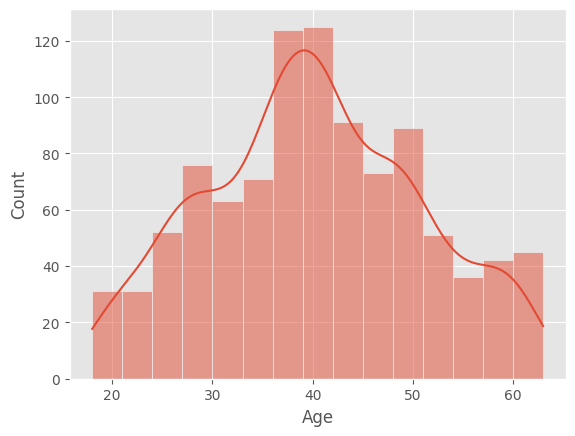

In [16]:
sns.histplot(dataset['Age'], kde=True)
plt.show


<Axes: xlabel='AnnualSalary', ylabel='Count'>

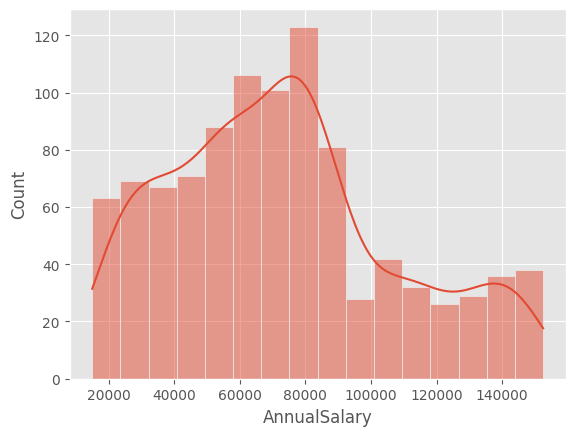

In [17]:
sns.histplot(dataset['AnnualSalary'],kde = True)

### dataset is less skewed and has less to no outliers

# 4. Model Development

In [18]:
dataset.columns

Index(['User ID', 'Age', 'AnnualSalary', 'Purchased', 'Gender_Female',
       'Gender_Male'],
      dtype='object')

In [19]:
# FIRST LET'S SPLIT DATASET INTO TRAIN-TEST & remove useless columns
# Drop the 'User ID' column
dataset = dataset.drop('User ID', axis=1)

In [20]:
dataset.head()

,Age,AnnualSalary,Purchased,Gender_Female,Gender_Male
0,35,20000,0,0,1
1,40,43500,0,0,1
2,49,74000,0,0,1
3,40,107500,1,0,1
4,25,79000,0,0,1


In [21]:
from sklearn.model_selection import train_test_split

# Splitting your dataset into features (X) and labels (y)
x = dataset.drop('Purchased', axis=1)  # Features
y = dataset['Purchased']  # Labels

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)



### GBM models focuses on reducing losse at each next step or epoch , so best for binary classification

### selected n_estimator = 20 , will change later if i see underfitting in training 

In [22]:
# Create our model
carp = lgb.LGBMRegressor(n_estimators=50,
                            learning_rate=0.05,
                            objective='binary',
                            metric=['binary_logloss'],
                            importance_type='gain'
                           )




### I am keeping early stopping value as 50 , as if kept higher value ( mostly for large datasets ) there is risk of overfitting , as our dataset is small; 1000 rows

### after iterations in model training , i found out results are same even if early stopping & verbose are not mentioned

In [23]:
# Fit our model
carp.fit(x_train, y_train,
            eval_set=(x_test,y_test)
           )

[LightGBM] [Info] Number of positive: 330, number of negative: 470
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.412500 -> initscore=-0.353640
[LightGBM] [Info] Start training from score -0.353640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(importance_type='gain', learning_rate=0.05,
              metric=['binary_logloss'], n_estimators=50, objective='binary')

In [24]:
y_pred = carp.predict(x_test)

In [25]:
y_pred 

array([0.03343518, 0.95279457, 0.77647147, 0.28605713, 0.35083623,
       0.1335863 , 0.17890848, 0.03330708, 0.89696658, 0.03343472,
       0.91084762, 0.03343329, 0.91925276, 0.41509728, 0.56202517,
       0.03343546, 0.89010718, 0.83305662, 0.03343122, 0.03313495,
       0.03330283, 0.03334042, 0.9527928 , 0.03650394, 0.03774088,
       0.20820909, 0.87514314, 0.95111419, 0.03315671, 0.03343541,
       0.03343533, 0.03451893, 0.05648649, 0.14795429, 0.18046551,
       0.03343442, 0.03330283, 0.22171427, 0.92098781, 0.90849922,
       0.03343074, 0.03324364, 0.88221865, 0.90619244, 0.14795429,
       0.94108912, 0.89358118, 0.03343541, 0.03343533, 0.03946818,
       0.88029039, 0.03330624, 0.94108912, 0.85944676, 0.03331189,
       0.95272929, 0.03594784, 0.03936794, 0.03343535, 0.03840072,
       0.28055261, 0.9066658 , 0.82124449, 0.85435395, 0.0355779 ,
       0.03343505, 0.92578805, 0.92138502, 0.9527928 , 0.92462539,
       0.03652022, 0.47647125, 0.26230144, 0.03946815, 0.28578

In [26]:
# MAKE Y_PRED AS 0 OR 1
threshold = 0.5
y_pred = (y_pred >= threshold).astype(int)
print(y_pred)

[0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0
 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0
 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0]


In [27]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
                          
print(f"Accuracy: {accuracy:.3f}")
# confusion matrix  and classification re
# port

from sklearn.metrics import confusion_matrix, classification_report     
cm = confusion_matrix(y_test, y_pred)







Accuracy: 0.920


In [28]:
print(cm)

[[120   8]
 [  8  64]]


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       128
           1       0.89      0.89      0.89        72

    accuracy                           0.92       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.92      0.92      0.92       200



## Accuracy of 0.92 is pretty good , considering , i didn't hypertuned the model better ( created test for automatic hypertuning & selecting the best parameters for LightGBM Model


# 5. Saving MODEL and model weights

In [30]:
import pickle

pickle.dump(carp,open('model.pkl','wb'))
model=pickle.load(open('model.pkl','rb'))


In [31]:
model=pickle.load(open('model.pkl','rb'))

In [32]:
model.predict([[19,19000,0,1]])

array([0.03343518])

In [33]:
model

LGBMRegressor(importance_type='gain', learning_rate=0.05,
              metric=['binary_logloss'], n_estimators=50, objective='binary')

## work continued in flask app